In [ ]:
from pathlib import Path
from typing import Callable, Any, cast

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoDetection
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn, fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights
import torchvision.transforms.functional as F
from ml_carbucks import DATA_CAR_DD_DIR
from ml_carbucks.utils.logger import setup_logger

IMG_SIZE = 320
BATCH_SIZE = 16
NUM_CLASSES = 4  # background + 3 object classes
# --- Dataset must return ---
# img: tensor [3,H,W]
# target: dict with:
#   boxes (FloatTensor [N,4]), labels (Int64Tensor [N])
#   optional: image_id, area, iscrowd



class COCODetectionWrapper(Dataset):
    def __init__(self, img_folder, ann_file, transforms=None):
        self.dataset = CocoDetection(img_folder, ann_file)
        self.transforms = transforms

        # Map COCO category IDs (non-sequential) -> continuous label IDs
        self.cat_id_to_label = {
            cat["id"]: idx + 1  # +1 because 0 = background
            for idx, cat in enumerate(self.dataset.coco.cats.values())
        }

    def __getitem__(self, idx):
        img, anns = self.dataset[idx]
        img = np.array(img, dtype=np.uint8)  # needed for Albumentations

        if len(anns) == 0:
            boxes_coco = np.zeros((0, 4), dtype=np.float32)
            labels = np.zeros((0,), dtype=np.int64)
        else:
            boxes_coco = np.array([ann["bbox"] for ann in anns], dtype=np.float32)
            boxes_coco = np.clip(boxes_coco, a_min=0, a_max=None)  # ensure non-negative
            labels = np.array([self.cat_id_to_label[ann["category_id"]] for ann in anns], dtype=np.int64)

        if self.transforms:
            sample = self.transforms(image=img, bboxes=boxes_coco.tolist(), labels=labels.tolist())
            img = sample["image"]
            boxes_coco = np.array(sample["bboxes"], dtype=np.float32)
            labels = np.array(sample["labels"], dtype=np.int64)

        # Convert COCO to VOC format
        if boxes_coco.shape[0] > 0:
            boxes_voc = boxes_coco.copy()
            boxes_voc[:, 2] += boxes_voc[:, 0]  # x + w → x2
            boxes_voc[:, 3] += boxes_voc[:, 1]  # y + h → y2
        else:
            boxes_voc = np.zeros((0, 4), dtype=np.float32)

        target = {
            "boxes": torch.from_numpy(boxes_voc),
            "labels": torch.from_numpy(labels),
            "image_id": torch.tensor(idx),
            "area": torch.from_numpy((boxes_voc[:, 2] - boxes_voc[:, 0]) * (boxes_voc[:, 3] - boxes_voc[:, 1])),
            "iscrowd": torch.zeros((boxes_voc.shape[0],), dtype=torch.int64),
        }

        return img, target


    def __len__(self):
        return len(self.dataset)


def create_transforms(is_training: bool) -> A.Compose:
    
    arr = []
    arr.extend([
        A.LongestMaxSize(max_size=IMG_SIZE),
        A.PadIfNeeded(
            min_height=IMG_SIZE,
            min_width=IMG_SIZE,
            border_mode=0,  # constant padding
            fill=(0, 0, 0),  # black
        ),
    ])
    if is_training:
        arr.append(A.HorizontalFlip(p=0.5))
    
    arr.extend([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])


    custom_transform = A.Compose(
        cast(
            Any,
            arr,
        ),
        bbox_params=A.BboxParams(
            format="coco",  # we now correctly pass COCO-format boxes in/out
            label_fields=["labels"],
            min_visibility=0.3,
        ),
    )

    return custom_transform
# --- Dataset ---
train_dataset = COCODetectionWrapper(
    img_folder=DATA_CAR_DD_DIR / "images" / "train",
    ann_file=DATA_CAR_DD_DIR / "instances_train.json",
    transforms=create_transforms(is_training=True),
)
val_dataset = COCODetectionWrapper(
    img_folder=DATA_CAR_DD_DIR / "images" / "val",
    ann_file=DATA_CAR_DD_DIR / "instances_val.json",
    transforms=create_transforms(is_training=False),
)

def collate_fn(batch):
    return tuple(zip(*batch))



train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,          # 2–8 is typical, memory permitting
    shuffle=True,
    num_workers=BATCH_SIZE // 2,         # adjust based on your CPU
    pin_memory=True,
    collate_fn=collate_fn, # crucial
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=BATCH_SIZE // 2,
    pin_memory=True,
    collate_fn=collate_fn,
)


logger = setup_logger("faster_rcnn")


In [ ]:
from ml_carbucks.utils.inference import plot_img_pred as ppp
imgs, targets = next(iter(train_loader))

iii = 5
print(imgs[iii], targets[iii])

ppp(imgs[iii], targets[iii]['boxes'], coords="xyxy")


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
# clean gpu memory 

torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
# model = fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
in_features = model.roi_heads.box_predictor.cls_score.in_features # type: ignore
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)
model = model.to(device)

# --- Optimizer ---
backbone_params = []
head_params = []
for name, param in model.named_parameters():
    if "backbone" in name:
        backbone_params.append(param)
    else:
        head_params.append(param)
optimizer = torch.optim.AdamW(
    [
        {"params": backbone_params, "lr": 5e-5, "weight_decay": 1e-4},
        {"params": head_params, "lr": 1e-3, "weight_decay": 1e-4},
    ]
)

EPOCHS = 200
# --- Scheduler (optional) ---
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)


# --- Training loop ---
num_epochs = EPOCHS
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for imgs, targets in tqdm(train_loader):

        imgs = list(img.to(device) for img in imgs)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        loss = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        loss.backward() # type: ignore
        optimizer.step()

        total_loss += loss.item() # type: ignore

    if scheduler:
        scheduler.step()

    # --- Validation on training data (resized) ---
    model.eval()
    metric = MeanAveragePrecision()
    with torch.no_grad():
        for imgs, targets in tqdm(val_loader):
            imgs = list(img.to(device) for img in imgs)
            outputs = model(imgs)

            # Prepare targets in expected dict format
            targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
            outputs_cpu = [{k: v.cpu() for k, v in t.items()} for t in outputs]
            metric.update(outputs_cpu, targets_cpu)

    val_res = metric.compute()
    metric.reset()
    logger.info(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | val_map: {val_res['map'].item():.4f}")

In [ ]:



# # --- Model ---
# num_classes = 4  # background + 3 classes
# model = fasterrcnn_resnet50_fpn(pretrained=True)

# # Replace the head (classifier)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)


# # --- Training Setup ---
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()
#     for imgs, targets in train_loader:
#         imgs = [img.to(device) for img in imgs]
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(imgs, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#     lr_scheduler.step()
#     print(f"Epoch {epoch+1}/{num_epochs}, loss: {losses.item():.4f}")


# model.eval()
# with torch.no_grad():
#     for imgs, _ in val_loader:
#         imgs = [img.to(device) for img in imgs]
#         preds = model(imgs)  # list of dicts with boxes, labels, scores


<Axes: title={'center': 'Training Loss and Validation mAP over Epochs'}, xlabel='epoch'>

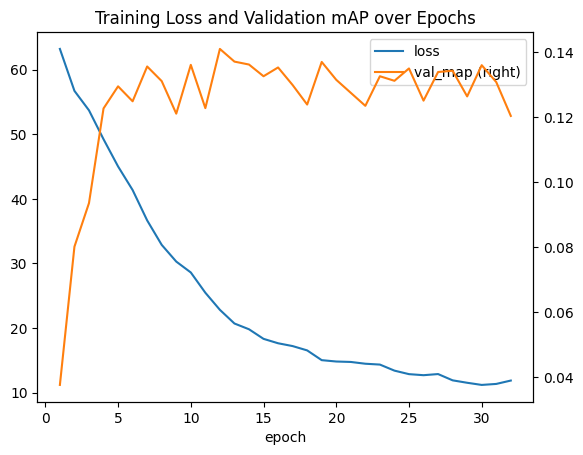

In [3]:
import pandas as pd
import re

log_text = """
INFO faster_rcnn 26/10/2025 15:40:55 [faster_rcnn.py:<module>:169] | Running Faster R-CNN training demo
INFO faster_rcnn 26/10/2025 15:45:28 [faster_rcnn.py:<module>:240] | Epoch 1/200 | Loss: 63.2107 | val_map: 0.0377
INFO faster_rcnn 26/10/2025 15:50:03 [faster_rcnn.py:<module>:240] | Epoch 2/200 | Loss: 56.7156 | val_map: 0.0802
INFO faster_rcnn 26/10/2025 15:54:38 [faster_rcnn.py:<module>:240] | Epoch 3/200 | Loss: 53.7015 | val_map: 0.0936
INFO faster_rcnn 26/10/2025 15:59:13 [faster_rcnn.py:<module>:240] | Epoch 4/200 | Loss: 49.2277 | val_map: 0.1227
INFO faster_rcnn 26/10/2025 16:03:48 [faster_rcnn.py:<module>:240] | Epoch 5/200 | Loss: 45.0115 | val_map: 0.1295
INFO faster_rcnn 26/10/2025 16:08:24 [faster_rcnn.py:<module>:240] | Epoch 6/200 | Loss: 41.3589 | val_map: 0.1249
INFO faster_rcnn 26/10/2025 16:13:01 [faster_rcnn.py:<module>:240] | Epoch 7/200 | Loss: 36.6558 | val_map: 0.1356
INFO faster_rcnn 26/10/2025 16:17:38 [faster_rcnn.py:<module>:240] | Epoch 8/200 | Loss: 32.8669 | val_map: 0.1311
INFO faster_rcnn 26/10/2025 16:22:15 [faster_rcnn.py:<module>:240] | Epoch 9/200 | Loss: 30.2798 | val_map: 0.1211
INFO faster_rcnn 26/10/2025 16:26:52 [faster_rcnn.py:<module>:240] | Epoch 10/200 | Loss: 28.5933 | val_map: 0.1361
INFO faster_rcnn 26/10/2025 16:31:29 [faster_rcnn.py:<module>:240] | Epoch 11/200 | Loss: 25.4550 | val_map: 0.1228
INFO faster_rcnn 26/10/2025 16:36:06 [faster_rcnn.py:<module>:240] | Epoch 12/200 | Loss: 22.8080 | val_map: 0.1410
INFO faster_rcnn 26/10/2025 16:40:43 [faster_rcnn.py:<module>:240] | Epoch 13/200 | Loss: 20.6919 | val_map: 0.1371
INFO faster_rcnn 26/10/2025 16:45:20 [faster_rcnn.py:<module>:240] | Epoch 14/200 | Loss: 19.7993 | val_map: 0.1362
INFO faster_rcnn 26/10/2025 16:49:56 [faster_rcnn.py:<module>:240] | Epoch 15/200 | Loss: 18.3151 | val_map: 0.1326
INFO faster_rcnn 26/10/2025 16:54:33 [faster_rcnn.py:<module>:240] | Epoch 16/200 | Loss: 17.6325 | val_map: 0.1353
INFO faster_rcnn 26/10/2025 16:59:10 [faster_rcnn.py:<module>:240] | Epoch 17/200 | Loss: 17.1951 | val_map: 0.1299
INFO faster_rcnn 26/10/2025 17:03:47 [faster_rcnn.py:<module>:240] | Epoch 18/200 | Loss: 16.5257 | val_map: 0.1239
INFO faster_rcnn 26/10/2025 17:08:24 [faster_rcnn.py:<module>:240] | Epoch 19/200 | Loss: 15.0155 | val_map: 0.1370
INFO faster_rcnn 26/10/2025 17:13:01 [faster_rcnn.py:<module>:240] | Epoch 20/200 | Loss: 14.8057 | val_map: 0.1315
INFO faster_rcnn 26/10/2025 17:17:38 [faster_rcnn.py:<module>:240] | Epoch 21/200 | Loss: 14.7370 | val_map: 0.1275
INFO faster_rcnn 26/10/2025 17:22:15 [faster_rcnn.py:<module>:240] | Epoch 22/200 | Loss: 14.4620 | val_map: 0.1235
INFO faster_rcnn 26/10/2025 17:26:53 [faster_rcnn.py:<module>:240] | Epoch 23/200 | Loss: 14.3312 | val_map: 0.1326
INFO faster_rcnn 26/10/2025 17:31:31 [faster_rcnn.py:<module>:240] | Epoch 24/200 | Loss: 13.3935 | val_map: 0.1312
INFO faster_rcnn 26/10/2025 17:36:08 [faster_rcnn.py:<module>:240] | Epoch 25/200 | Loss: 12.8494 | val_map: 0.1350
INFO faster_rcnn 26/10/2025 17:40:45 [faster_rcnn.py:<module>:240] | Epoch 26/200 | Loss: 12.6867 | val_map: 0.1251
INFO faster_rcnn 26/10/2025 17:45:22 [faster_rcnn.py:<module>:240] | Epoch 27/200 | Loss: 12.8625 | val_map: 0.1339
INFO faster_rcnn 26/10/2025 17:49:58 [faster_rcnn.py:<module>:240] | Epoch 28/200 | Loss: 11.8898 | val_map: 0.1343
INFO faster_rcnn 26/10/2025 17:54:35 [faster_rcnn.py:<module>:240] | Epoch 29/200 | Loss: 11.5139 | val_map: 0.1264
INFO faster_rcnn 26/10/2025 17:59:13 [faster_rcnn.py:<module>:240] | Epoch 30/200 | Loss: 11.1806 | val_map: 0.1360
INFO faster_rcnn 26/10/2025 18:03:50 [faster_rcnn.py:<module>:240] | Epoch 31/200 | Loss: 11.3344 | val_map: 0.1308
INFO faster_rcnn 26/10/2025 18:08:27 [faster_rcnn.py:<module>:240] | Epoch 32/200 | Loss: 11.8577 | val_map: 0.1204
"""

# regex to extract epoch, loss, val_map
pattern = r"Epoch (\d+)/\d+ \| Loss: ([\d\.]+) \| val_map: ([\d\.]+)"
matches = re.findall(pattern, log_text)

# convert to dataframe
df = pd.DataFrame(matches, columns=["epoch", "loss", "val_map"])
df = df.astype({"epoch": int, "loss": float, "val_map": float})


df.plot(x="epoch", y=["loss", "val_map"], secondary_y="val_map", title="Training Loss and Validation mAP over Epochs")

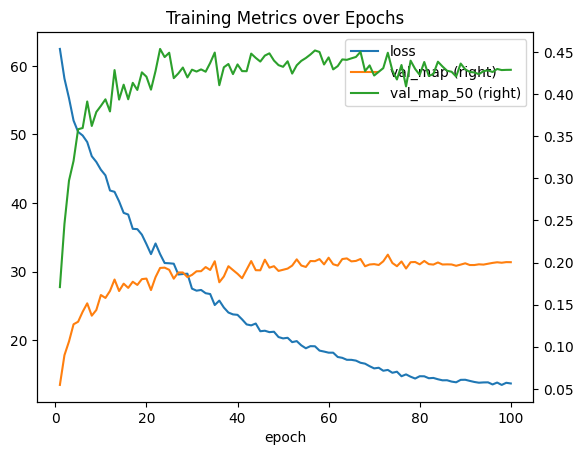

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

from ml_carbucks import RESULTS_DIR

res_df = pd.read_csv(RESULTS_DIR / "faster_rcnn" / "training_results_20251026_200719.csv")

res_df.plot(
    x="epoch",
    y=["loss", "val_map", "val_map_50"],
    secondary_y=["val_map", "val_map_50"],
    title="Training Metrics over Epochs",
)

plt.show()
